## <i>Radiomics analysis examples based on classicial machine learning algorithms (non deep learning models) <br>
    
This tutorial shows how to develop a standard radiomics pipeline for the classification tasks. <br>
The following features will be illustrated and dicussed: <br><br>
<b>1. Radiomic feature extraction.</b> '<i>example based on a large-scale lung nodule dataset</i>'<br>
<b>2. Basic classification models.</b> <br>
<b>3. Fine tuning model parameters.</b> <br>
<b>4. Class imbalance issues.</b> <br>
<b>5. Cross validation analysis</b> <br>
<b>6. Dimensionality reduction and feature selection.</b> <br>
<b>7. Determining robust radiomics signature.</b> <br>
<b>8. Model validation.</b> <br>

### <b>1. Radiomic feature extraction <br><br>
Extracting the radiomic feature will be done by employing the standard open-source Python package developed for radiomic features in medical imaging known as __[PyRadiomics](https://pyradiomics.readthedocs.io/en/latest/)__. <br><br>
The __[Kaggle Data Science Bowl 2017](https://www.kaggle.com/c/data-science-bowl-2017)__ contains a total number of 2101 clinical chest Low-Dose Computed Tomography scans from which 1397, 198, and 506 subjects belong to the training, validation, and test sets, respectively.<br> The goal of the challenge was to automatically predict lung cancer status; for that, each image was labeled as “1” if the patient was diagnosed with lung cancer within one year from the scan and “0” otherwise. Therefore, the idea was to develope a model to predict the binary cancer status.<br> The challenge organizer provided .dcm image data and a .csv file with the corresponding cancer status but not the segmentation masks or coordinates of the lung nodules. <br> From 1397 training subjects, 968 LDCT scans were manually examined by an expert radiologist and 1297 pulmonary nodules were delineated.<br>
Therefore, we want to load the original LDCT scans along with their corresponding segmentation masks to extract the radiomic features.<br><br>
The following figure shows the 2D axial views of four cases. The first row represents the benign lung nodules while the second rows demonstrates the malignant nodule. As it can be seen from the examples, visually distinguishing these two classes from each other is a demanding task as they shared numerous visual characteristics.

In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt

img_example_dir = glob.glob('../data_slice_example/*.png')
images = []
for img in img_example_dir:
    images.append(cv2.imread(img))
    
fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 2
for ind in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, ind)
    plt.imshow(images[ind-1])


The structure of the data directory is as follow:

├── <i>stage1_labels.csv</i> <br>
├── <b>train</b> <br>
│   ├── <b>006b96310a37b36cccb2ab48d10b49a3</b><br>
│   │   ├── 006b96310a37b36cccb2ab48d10b49a3_cropped.nii.gz<br>
│   │   ├── 006b96310a37b36cccb2ab48d10b49a3_list.json<br>
│   │   ├── 006b96310a37b36cccb2ab48d10b49a3_mask.nii.gz<br>
│   │   └── 006b96310a37b36cccb2ab48d10b49a3.nii.gz<br>
│   ├── <b>008464bb8521d09a42985dd8add3d0d2</b><br>
│   │   ├── 008464bb8521d09a42985dd8add3d0d2_cropped.nii.gz<br>
│   │   ├── 008464bb8521d09a42985dd8add3d0d2_list.json<br>
│   │   ├── 008464bb8521d09a42985dd8add3d0d2_mask.nii.gz<br>
│   │   └── 008464bb8521d09a42985dd8add3d0d2.nii.gz<br>
...<br><br>

This structure essentially means that for each subject there is a directory that entails the original image data in .nii.gz file format, a cropped patches around the nodule (filename_cropped), a segmentation mask (filename_mask), and a json file containing some patient features. However, the class labels of the data is provided in a .csv file with the following format:<br><br>


id | cancer
:---|:---:|
**006b96310a37b36cccb2ab48d10b49a3** | 1 |
**008464bb8521d09a42985dd8add3d0d2** | 1 |
...

Considering this structure the following scripts are prepared to load each data with corresponding segmentation mask for feature extraction. Please note that the spatial resolution of the main image and corresponding segmentation masks should be similar. In this example, all the images and masks were isotropically resampled to $0.2mm^{2}$. <br> <b>For your own dataset</b>, then, you can create two lists/dictionary etc containing the full directory
to the images and corresponding masks along with the class labels of the subjects. It is important to make sure
that order of the filenames in such two lists/dictionaries are the same.

In [1]:
# importing the required libraries
import os
import sys
import six
import glob
import pandas as pd
from radiomics import featureextractor
sys.path.append('../../radiomics_pipeline/')
from data_loader.sitk_stuff import read_nifti
from data_loader.paths_and_dirs import get_filepath, match_img_label, read_csv_file

In [2]:
# set a filename for the extracted features.
radiomic_feature_name = 'radiomic_features_test.csv' 
# dir csv file
lung_nodule_csv_path = '/media/mehdi/KTH/DeepLearning/DataRepository/Lung Nodule/data/Lung_CT/' 
# dir to image data
data_path = '/media/mehdi/KTH/DeepLearning/DataRepository/Lung Nodule/data/Lung_CT/train/' 

In [3]:
# set dir to write the extracted features in a .csv file
radiomic_path_write = os.path.join('../features/', radiomic_feature_name)
# loading the lung nodule csv file that contains the class labels
csv_path = glob.glob(lung_nodule_csv_path + "*.csv")
csv_contents = read_csv_file(csv_path[0])
# get image and mask paths
img_path = get_filepath(data_path, 'cropped')
mask_path = get_filepath(data_path, 'mask')
# match the image data to the .csv file and labels
samples_img = match_img_label(img_path, csv_contents)
samples_msk = match_img_label(mask_path, csv_contents)
data_length = len(samples_img)

In [6]:
print(data_length)

1297


In [13]:
# Instantiating Radiomics Feature Extraction
extractor = featureextractor.RadiomicsFeatureExtractor()
# the params.yaml file set the type of features we want to extract.
# It is set to extract all the first order, 2nd order, geometric, 
# wavelet-based features and LoG for the following sigma values [0.5, 1, 1.5]
param_path = os.path.join(os.getcwd(), 'params.yaml')
extractor = featureextractor.RadiomicsFeatureExtractor(param_path)
print('Extraction parameters:''\n'*3, extractor.settings)
print('Enabled filters:\n*16', extractor.enabledImagetypes)
print('Enabled features:\n*16', extractor.enabledFeatures)

Extraction parameters:
Extraction parameters:
Extraction parameters:
 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25, 'weightingNorm': None}
Enabled filters:
*16 {'Original': {}, 'LoG': {'sigma': [0.5, 1, 1.5]}, 'Wavelet': {}}
Enabled features:
*16 {'shape': [], 'firstorder': [], 'glcm': [], 'glrlm': [], 'glszm': [], 'gldm': []}


In [ ]:
# data will be called one by one and the extracted features will be saved in a .csv file
for ind in range(len(samples_img)):
    
    img_path = samples_img[ind][0]
    mask_path = samples_msk[ind][0]
    subject_name = os.path.split(img_path)[-1]
    subject_label = samples_img[ind][1]
    
    print('\n'*10)
    print('working on case {} out of {}:'.format(ind+1, data_length))
    print('\n'*10)
    
    
    img_itk, img_size, img_spacing, _, _ = read_nifti(img_path)
    mask_itk, mask_size, mask_spacing, _, _ = read_nifti(mask_path)
    
    assert img_size == mask_size and img_spacing == mask_spacing, "image and mask should have the same size and spacing!"
    features = extractor.execute(img_itk, mask_itk)
    features_all = {}
    for key, value in six.iteritems(features):
        if key.startswith('original') or key.startswith('wavelet') or \
        key.startswith('log'):
            features_all['Subject_ID'] = subject_name
            features_all['Subject_Label'] = subject_label
            features_all[key] = features[key]
            
    df = pd.DataFrame(data=features_all,  index=[ind])
    if ind == 0:
        df.to_csv(radiomic_path_write, mode='a')
    else:
        df.to_csv(radiomic_path_write, header = None, mode='a')

From the following setting a total number of 1070 features were extracted from each subject.<br>
The structure of the 'radiomic_features_test.csv' file is:

number | Subject_ID | Subject_Label | original_shape_Elongation |original_shape_Flatness | other features... |
:---|:---:|:---:|:---:|:---:|:---:|
0 | c928b4fee44ea322ac65348ae2ff20b8_cropped | 0 | 0.576 | 0.540 | feature values... |
1 | 91ee390b30927af8804d1f2adf2aefa8_cropped | 0 | 0.849 | 0.673 | feature values... |
2 |  76fff2029e577190ce0bf070192b889e_cropped - Copy |0 |0.8448 | 0.722|feature values... |
3 |f43843b39a5be8cd30dab59bd11499ed_cropped - Copy|0|0.789|0.521|feature values... |
4 |184fa4ae2b7ae010625d89f10186f1c5_cropped|1|0.913|0.894|feature values... |
...

### <b>2. Basic classification<br><br>

The next step is to develop a predictive model. In this repo we employ the __[SKLEARN](https://scikit-learn.org/stable/)__ library for preprocessing the data, developing the predictive models, training and testing the compiled models. <br>
Some of the most conventional learning algorithms were scripted in the '../learning_algorithms/models.py'. The training procedures of the models is already developed in the '../training/trainer.py' <br><br>
Generally, building a predictive model consists of these steps:<br>
1. Loading the feature matrix
2. Shuffling the order of the data
3. Splitting the data into train and test subsets.
4. Train the model on the training subset
5. Evaluate the performance of the learned model on the test subset. <br>

Implementation of these steps would be like:

In [14]:
# importing the libraries
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append('../../radiomics_pipeline/')

import pandas as pd
import matplotlib.pyplot as plt
from training.trainer import learning
from learning_algorithms.models import decicion_tree
from learning_algorithms.models import random_forest, naive
from learning_algorithms.models import knn, adab_tree, lda, qda
from sklearn.model_selection import train_test_split
from data_loader.feature_loader import load_radiomic_set
from utilities.feature_tools import feature_normalization, data_shuffling

In [15]:
# loading the radiomics features
path_to_radiomics = '../features/radiomic_features_test.csv'
subject_ids ,features_names, feature_set, label_set = load_radiomic_set(path_to_radiomics)

In [17]:
label_set.shape


(1297,)

In [19]:
# randomly shuffle the order of the data
seed_val = 70 # a random integer
feature_set, label_set = data_shuffling(feature_set, label_set, seed_val)
print('the size of the feature matrix is {}'.format(feature_set.shape))

the size of the feature matrix is (1297, 1070)


In [20]:
# splitting the data into subsets
x_train, x_val, y_train, y_val = train_test_split(feature_set,
                                                    label_set,
                                                    test_size=0.2, # assigning 20% of the data to the test set.
                                                    random_state=None)
print('the size of the training subset is {}'.format(x_train.shape))
print('the size of the validation subset is {}'.format(x_val.shape))

the size of the training subset is (1037, 1070)
the size of the validation subset is (260, 1070)


In [21]:
# compiling the model with default settings
clf_dt = decicion_tree()

In [22]:
# training the compiled model with train data and evaluate it on the validation set.
clf_dt_summary = learning(clf_dt, x_train, y_train, x_val, y_val, x_test=None)

The following evaluation metrics are stored in the clf_summary dictionary:<br>
accuracy, sensitivity, specificty, AUROC of the validation set.
Moreover, the predicted probability of the validation sets, for each single subject, is stored
for further statistical analyses, if needed.<br>
In addition, if the x_test is provided and is not None, the predicted probabilities of the test
set will be stored as well.

In [23]:
print('The acc, sen, spc, and auc values of the validation set are {a:1.3f},{b:1.3f}, {c:1.3f} and {d:1.3f}'.format(
      a=clf_dt_summary['val_accuracy'], b=clf_dt_summary['val_sensitivity'],
      c=clf_dt_summary['val_specificity'], d=clf_dt_summary['val_auc']))

The acc, sen, spc, and auc values of the validation set are 0.685,0.448, 0.803 and 0.538


Now, lets try the previous steps with other learning algorithms as well.<br>
This time, we use the Random Forest, KNN and adaptive boosting, LDA, QDA and naive models:

In [24]:
clf_rf = random_forest()
clf_knn = knn()
clf_adab = adab_tree()
clf_lda = lda()
clf_qda = qda()
clf_naive = naive()

In [25]:
clf_rf_summary = learning(clf_rf, x_train, y_train, x_val, y_val, x_test=None)
clf_lda_summary = learning(clf_lda, x_train, y_train, x_val, y_val, x_test=None)
clf_qda_summary = learning(clf_qda, x_train, y_train, x_val, y_val, x_test=None)
clf_adab_summary = learning(clf_adab, x_train, y_train, x_val, y_val, x_test=None)
clf_knn_summary = learning(clf_knn, x_train, y_train, x_val, y_val, x_test=None)
clf_naive_summary = learning(clf_naive, x_train, y_train, x_val, y_val, x_test=None)

We can compare the performance of the models on the same data with:

In [26]:
compare_summary = {'AUC':[clf_rf_summary['val_auc'],clf_knn_summary['val_auc'],
                         clf_adab_summary['val_auc'],clf_lda_summary['val_auc'], clf_qda_summary['val_auc'],
                          clf_naive_summary['val_auc'],clf_dt_summary['val_auc']],
                  'ACC':[clf_rf_summary['val_accuracy'],
                          clf_knn_summary['val_accuracy'], clf_adab_summary['val_accuracy'],
                          clf_lda_summary['val_accuracy'], clf_qda_summary['val_accuracy'],
                          clf_naive_summary['val_accuracy'],clf_dt_summary['val_accuracy']]}

pd.DataFrame.from_dict(compare_summary, orient='index',
                       columns=['RF', 'KNN', 'Adab', 'LDA', 'QDA', 'Naive', 'DT'])

,RF,KNN,Adab,LDA,QDA,Naive,DT
AUC,0.758521,0.64504,0.695967,0.553352,0.500000,0.684838,0.538436
ACC,0.750000,0.65000,0.707692,0.569231,0.334615,0.696154,0.684615


### <b>3. Fine-tuning the models to improve the performance<br><br>
In the previous section, several learning models were employed with default settings.<br>
In the following we invetigate the effects of parameters tuning on the model performance.

We start by tuning the Random Forest parameters. <br>
The funciton 'random_forest(n_estimators=10, criterion='gini', max_depth=5, class_weight=None)' gets four arguments.<bt> The idea is to change these parameters to find out whether they would improve the model performance or not.

In [33]:
# start by changing the number of estimators:
estimators = range(1,100)
rf_auc_estimators = {}
for n_estimator in estimators:
    clf_rf = random_forest(n_estimators=n_estimator, criterion='gini', max_depth=5, class_weight=None)
    clf_rf_summary = learning(clf_rf, x_train, y_train, x_val, y_val, x_test=None)
    rf_auc_estimators[n_estimator] = clf_rf_summary['val_auc']

In [34]:
rf_estimate_x_axis = list(rf_auc_estimators.keys())
rf_estimate_y_axis = list(rf_auc_estimators.values())

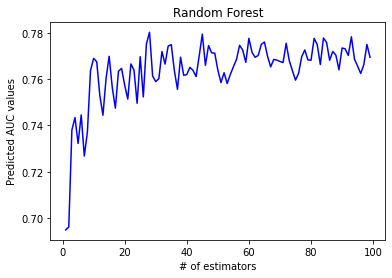

In [35]:
plt.plot(rf_estimate_x_axis, rf_estimate_y_axis, color='blue')
plt.title("Random Forest")
plt.xlabel("# of estimators")
plt.ylabel("Predicted AUC values");

In [39]:
# For a fixed number of estimators we change the max_depth of the trees:
depths = range(1,50)
rf_auc_depth = {}
for n_depth in depths:
    clf_rf = random_forest(n_estimators=20, criterion='gini', max_depth=n_depth, class_weight=None)
    clf_rf_summary = learning(clf_rf, x_train, y_train, x_val, y_val, x_test=None)
    rf_auc_depth[n_depth] = clf_rf_summary['val_auc']


In [40]:
rf_depth_x_axis = list(rf_auc_depth.keys())
rf_depth_y_axis = list(rf_auc_depth.values())

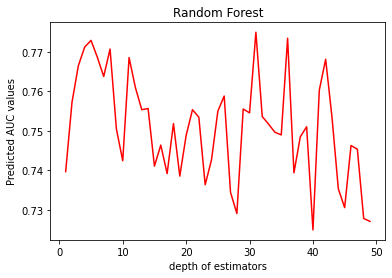

In [41]:
plt.plot(rf_depth_x_axis, rf_depth_y_axis, color='red')
plt.title("Random Forest")
plt.xlabel("depth of estimators")
plt.ylabel("Predicted AUC values");

As it can be observed, changing the model parameters would lead to significant changes in the performance of the models. However, the optimum values of such parameters are usually calculated experimentally. <br>
As an another example, we conduct the same type of experiments with Adab model. <br>
Emloying the _[SKLEARN Grid Search](https://scikit-learn.org/stable/modules/grid_search.html)_ is an standard way to determine the best settings of hyperparameters for a certain model. 

In [42]:
# Changing the depth of the trees:
adab_depth = range(1,30)
adab_auc_depth = {}
for n_depth in adab_depth:
    clf_adab = adab_tree(max_depth=n_depth, criterion='gini', class_weight=None, n_estimators=10)
    clf_adab_summary = learning(clf_adab, x_train, y_train, x_val, y_val, x_test=None)
    adab_auc_depth[n_depth] = clf_adab_summary['val_auc']

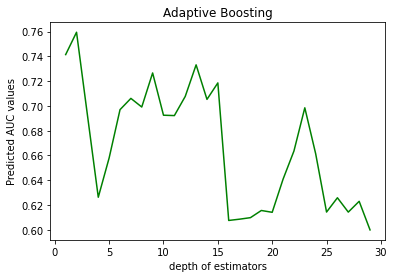

In [43]:
adab_depth_x_axis = list(adab_auc_depth.keys())
adab_depth_y_axis = list(adab_auc_depth.values())
plt.plot(adab_depth_x_axis, adab_depth_y_axis, color='green')
plt.title("Adaptive Boosting")
plt.xlabel("depth of estimators")
plt.ylabel("Predicted AUC values");

In [44]:
# Changing the number of estimators:
adab_estimator = range(1,50)
adab_auc_estimator = {}
for n_estimate in adab_estimator:
    clf_adab = adab_tree(max_depth=7, criterion='gini', class_weight=None, n_estimators=n_estimate)
    clf_adab_summary = learning(clf_adab, x_train, y_train, x_val, y_val, x_test=None)
    adab_auc_estimator[n_estimate] = clf_adab_summary['val_auc']

KeyboardInterrupt: 

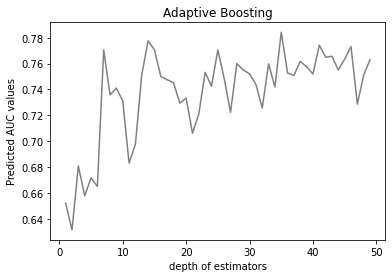

In [20]:
adab_depth_x_axis = list(adab_auc_estimator.keys())
adab_depth_y_axis = list(adab_auc_estimator.values())
plt.plot(adab_depth_x_axis, adab_depth_y_axis, color='gray')
plt.title("Adaptive Boosting")
plt.xlabel("depth of estimators")
plt.ylabel("Predicted AUC values");

### <b>4. Class imbalance issue<br><br>

Generally speaking, in the previous experiments, we did not examine whether the class labels are balanced or not.
Therefore, the models were compiled assuming that there are equal number of datapoints in each class. However, class imbalance issue poses a challenge to the predictive models and, in general, degrade the model performance especially for the minority class. To tackle this issue, different strategies have been proposed including:<br>
-  oversampling from minority class
-  undersampling from majority class
-  modifying the objective(loss) function
-  adding class weights
-  synthesizing new data for minority class <br>

In the following, we investigate the effect of "adding class weights" and "synthesizing new data".

From 1297 data 876 are benign and 421 are labeled as malignant


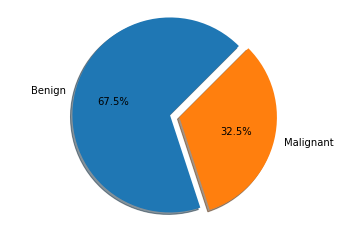

In [45]:
# first, we examine the distribution of the class labels in the dataset:
label_set_tuple = tuple(label_set)
benign_frequency = label_set_tuple.count(0)
malignant_frequency = label_set_tuple.count(1)
print('From {} data {} are benign and {} are labeled as malignant'.format(
    len(label_set_tuple),benign_frequency, malignant_frequency))
data_labels = ('Benign', 'Malignant')
values = [benign_frequency, malignant_frequency]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=data_labels, autopct='%1.1f%%',
        shadow=True, startangle=45)
ax1.axis('equal')  
plt.show()

In [46]:
# adding class weights as a dictionary and compare against the same model but without class weights.
clf_rf_base = random_forest(n_estimators=100, criterion='gini', max_depth=15, class_weight=None)
clf_rf_class_weight = random_forest(n_estimators=100, criterion='gini', max_depth=15, class_weight={0:1,1:2})

In [47]:
clf_rf_base_summary = learning(clf_rf_base, x_train, y_train, x_val, y_val, x_test=None)
clf_rf_class_weight_summary = learning(clf_rf_class_weight, x_train, y_train, x_val, y_val, x_test=None)
print('the performance of the base model is {a:1.3f} and the model with added class weight is {b:1.3f}'.format(
    a = clf_rf_base_summary['val_auc'], b = clf_rf_class_weight_summary['val_auc']))

the performance of the base model is 0.761 and the model with added class weight is 0.761


As can bee seen, although class weight is an efficient strategy, but yet I won't lead to a remarkable improvement of the model performance.<br>
As an alternative, we can employ the 'Synthetic Minority Oversampling Technique <b>(SMOTE)</b>' algorithm to synthetically generate new data for the minority class that eventually balance the class labels.

In [48]:
from preprocessing.class_balancing import smote_balancing
feature_set_balanced, label_set_balanced = smote_balancing(feature_set, label_set)

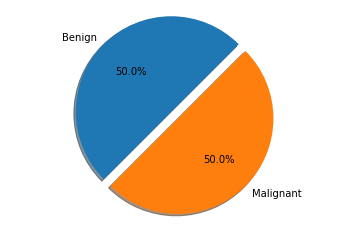

In [49]:
label_set_balanced_tuple = tuple(label_set_balanced)
benign_balanced = label_set_balanced_tuple.count(0)
malignant_balanced = label_set_balanced_tuple.count(1)
data_labels = ('Benign', 'Malignant')
values = [benign_balanced, malignant_balanced]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=data_labels, autopct='%1.1f%%',
        shadow=True, startangle=45)
ax1.axis('equal')  
plt.show()

In [50]:
# splitting the data into subsets
x_train, x_val, y_train, y_val = train_test_split(feature_set_balanced,
                                                    label_set_balanced,
                                                    test_size=0.2, # assigning 20% of the data to the test set.
                                                    random_state=None)

In [51]:
clf_rf_base = random_forest(n_estimators=100, criterion='gini', max_depth=15, class_weight=None)
clf_rf_base_summary = learning(clf_rf_base, x_train, y_train, x_val, y_val, x_test=None)
print('the performance of the base model with balanced data set is {}'.format(
    clf_rf_base_summary['val_auc']))

the performance of the base model with balanced data set is 0.9115097402597402


### <b>5. Important role of cross validation <br><br>
    
Even though balancing the feature sets led to significant improvement in the model performance, we should not
rely only on the achieved values. It would just happened by chance that well-handled data were splited to validation set. To tackle this issue, it has been highly recommended to perform the analyses by following the cross validation approach.<br>
In the following, we perform the k-fold cross validation experiments on the balanced dataset:

In [52]:
from sklearn.model_selection import KFold
from utilities.feature_tools import train_val_split, cross_val_stats

In [53]:
seed_val = 150
n_fold_split = 5

feature_set_balanced, label_set_balanced = data_shuffling(feature_set_balanced, label_set_balanced, seed_val)

In [54]:
fold_num = 0
kf = KFold(n_splits = n_fold_split, shuffle = False) 
fold_stats = {}
for train_index, val_index in kf.split(label_set):
    fold_num += 1
    fold_name = 'fold_'+str(fold_num)
    print('Working on fold: {}'.format(fold_num))
    
    x_train, x_val, y_train, y_val = train_val_split(
        feature_set_balanced, label_set_balanced, train_index, val_index)    

    clf = random_forest(n_estimators=100, criterion='gini', max_depth=5, class_weight=None)
    clf_summary = learning(clf, x_train, y_train, x_val, y_val, x_test=None)
    fold_stats[fold_name] = clf_summary

Working on fold: 1
Working on fold: 2
Working on fold: 3
Working on fold: 4
Working on fold: 5


In [31]:
mean_acc, mean_sen, mean_spc, mean_auc, _, _, _, _ = cross_val_stats(fold_stats)

compare_summary = {'Accuracy_mean':mean_acc,'Sensitivity_mean':mean_sen,
                  'Specificity_mean': mean_spc,'AUC_mean': mean_auc}

pd.DataFrame.from_dict(compare_summary, orient='index',
                       columns=['Evaluation metrics of cross validation'])

,Evaluation metrics of cross validation
Accuracy_mean,0.760199
Sensitivity_mean,0.789794
Specificity_mean,0.731735
AUC_mean,0.844567


The observed results assure us that the predicted results were not achieved by chance. However, this argument
will be more strengthen if we repeat the cross validation several times after randomly shuffle the data. This will be detailed in section 7. <br>
In some cases, we also need to <b>normalize the data</b> before training the models.<br>
In specific, in radiomic feature pools,different features have different range of values that would significantly differ from each other. There are a number of ways to normalize the feature values and rescale them into a fixed range like [0,1].<br> What is important is to normalize the training data and, then, use the normalization parameters of the training set for rescaling the validation and test sets:


In [32]:
from utilities.feature_tools import feature_normalization

In [33]:
fold_num = 0
kf = KFold(n_splits = n_fold_split, shuffle = False) 
fold_stats = {}
for train_index, val_index in kf.split(label_set):
    fold_num += 1
    fold_name = 'fold_'+str(fold_num)
    print('Working on fold: {}'.format(fold_num))
    
    x_train, x_val, y_train, y_val = train_val_split(
        feature_set_balanced, label_set_balanced, train_index, val_index)
    
    x_train, x_val, _ = feature_normalization(x_train, x_val, x_test = None)

    clf = random_forest(n_estimators=100, criterion='gini', max_depth=5, class_weight=None)
    clf_summary = learning(clf, x_train, y_train, x_val, y_val, x_test=None)
    fold_stats[fold_name] = clf_summary

Working on fold: 1
Working on fold: 2
Working on fold: 3
Working on fold: 4
Working on fold: 5


In [55]:
mean_acc, mean_sen, mean_spc, mean_auc, _, _, _, _ = cross_val_stats(fold_stats)

compare_summary = {'Accuracy_mean':mean_acc,'Sensitivity_mean':mean_sen,
                  'Specificity_mean': mean_spc,'AUC_mean': mean_auc}

pd.DataFrame.from_dict(compare_summary, orient='index',
                       columns=['Evaluation metrics of cross validation'])

,Evaluation metrics of cross validation
Accuracy_mean,0.773300
Sensitivity_mean,0.816198
Specificity_mean,0.735185
AUC_mean,0.850255


### <b>6. Feature selection and dimensionality reduction <br><br>

It would be possible that many of extracted radiomic features are linearly/non-linearly associated to each other.
In addition, some features would not be informative and their presence just confuse the learning algorithms.
Moreover, in dealing with the limited number of data, large number of features would increase the risk of overfitting.<br>
Accordingly, one practical approach is to reduce the dimensionality of the featur sets by removing non-informative features.<br>
In a broad definition, two of the most conventional feature selection families are known as <b>filter-based methods</b> and <b>'wrapper-based methods'</b>. <br>
In this repo the following filter methods are implemented:<br>
- constant: <i>removing constant features</i><br>
- uncorrelated: <i>removing correlated(highly correlated) features</i><br>
- lasso: <i>Least Absolute Shrinkage and Selection Operator</i><br>
- reliefF: <i>Extended Relevance in Estimatory Features (RELIEF)</i><br>
- pca: <i>dimensionality redocution with linear/kernel-based PCA</i><br>
- mutual_info: <i>removing nonlinearly correlated features</i><br>
And<br>
- sequential feature selection: <i>as a wrapper method<i/>

In [56]:
from feature_selections.feature_selectors import lasso, relief, pca_linear

In [57]:
# example of feature selection with LASSO
fold_num = 0
kf = KFold(n_splits = n_fold_split, shuffle = False) 
fold_stats = {}
for train_index, val_index in kf.split(label_set):
    fold_num += 1
    fold_name = 'fold_'+str(fold_num)
    print('Working on fold: {}'.format(fold_num))
    
    x_train, x_val, y_train, y_val = train_val_split(
        feature_set_balanced, label_set_balanced, train_index, val_index)
    
    x_train, x_val, _ = feature_normalization(x_train, x_val, x_test = None)
    
    feature_selector = lasso(x_train, y_train, x_val, x_test=None, n_fold=5, max_iters=50, thr=0.5)
    x_train = feature_selector['train']
    x_val = feature_selector['val']
    feature_indices = feature_selector['feature_indices']
    fold_name_features = fold_name+'_selected_features'
    fold_stats[fold_name_features] = feature_indices
    
    clf = random_forest(n_estimators=100, criterion='gini', max_depth=5, class_weight=None)
    clf_summary = learning(clf, x_train, y_train, x_val, y_val, x_test=None)
    fold_stats[fold_name] = clf_summary
    
mean_acc, mean_sen, mean_spc, mean_auc, _, _, _, _ = cross_val_stats(fold_stats)
print('the average AUC value of {} fold cross validation with LASSO feature selection is: {}'.format(n_fold_split, mean_auc))

Working on fold: 1
Working on fold: 2
Working on fold: 3
Working on fold: 4
Working on fold: 5
the average AUC value of 5 fold cross validation with LASSO feature selection is: 0.8208735009023027


In [58]:
# example of relief feature selection
fold_num = 0
kf = KFold(n_splits = n_fold_split, shuffle = False) 
fold_stats = {}
for train_index, val_index in kf.split(label_set):
    fold_num += 1
    fold_name = 'fold_'+str(fold_num)
    print('Working on fold: {}'.format(fold_num))
    
    x_train, x_val, y_train, y_val = train_val_split(
        feature_set_balanced, label_set_balanced, train_index, val_index)
    
    x_train, x_val, _ = feature_normalization(x_train, x_val, x_test = None)
    
    feature_selector = relief(x_train, y_train, x_val, x_test = None, n_neighbors=5, n_features=10)
    x_train = feature_selector['train']
    x_val = feature_selector['val']
    
    clf = random_forest(n_estimators=100, criterion='gini', max_depth=5, class_weight=None)
    clf_summary = learning(clf, x_train, y_train, x_val, y_val, x_test=None)
    fold_stats[fold_name] = clf_summary
    
mean_acc, mean_sen, mean_spc, mean_auc, _, _, _, _ = cross_val_stats(fold_stats)
print('the average auc value of {} fold cross validation with RELIEFF feature selection is: {}'.format(n_fold_split, mean_auc))

Working on fold: 1
Working on fold: 2
Working on fold: 3
Working on fold: 4
Working on fold: 5
the average auc value of 5 fold cross validation with RELIEFF feature selection is: 0.6917673832187069


In [59]:
# example of PCA-based dimensionality reduction
fold_num = 0
kf = KFold(n_splits = n_fold_split, shuffle = False) 
fold_stats = {}
for train_index, val_index in kf.split(label_set):
    fold_num += 1
    fold_name = 'fold_'+str(fold_num)
    print('Working on fold: {}'.format(fold_num))
    
    x_train, x_val, y_train, y_val = train_val_split(
        feature_set_balanced, label_set_balanced, train_index, val_index)
    
    x_train, x_val, _ = feature_normalization(x_train, x_val, x_test = None)
    
    feature_selector = pca_linear(x_train, x_val, x_test = None, n_component=25)
    x_train = feature_selector['train']
    x_val = feature_selector['val']
    
    clf = random_forest(n_estimators=100, criterion='gini', max_depth=5, class_weight=None)
    clf_summary = learning(clf, x_train, y_train, x_val, y_val, x_test=None)
    fold_stats[fold_name] = clf_summary
    
mean_acc, mean_sen, mean_spc, mean_auc, _, _, _, _ = cross_val_stats(fold_stats)
print('the average auc value of {} fold cross validation with PCA dim reduction is: {}'.format(n_fold_split, mean_auc))

Working on fold: 1
Working on fold: 2
Working on fold: 3
Working on fold: 4
Working on fold: 5
the average auc value of 5 fold cross validation with PCA dim reduction is: 0.8313191293764968


In [60]:
# Investigating the effect of the number of PCA components on the prediction power:
n_component = range(2,31)
pca_stats = {}
for pca_component in n_component:
    print('Working on 5fold cross val with {} number of PCA components'.format(pca_component))
    kf = KFold(n_splits = n_fold_split, shuffle = False) 
    fold_stats = {}
    for train_index, val_index in kf.split(label_set):       
        x_train, x_val, y_train, y_val = train_val_split(
            feature_set_balanced, label_set_balanced, train_index, val_index)

        x_train, x_val, _ = feature_normalization(x_train, x_val, x_test = None)

        feature_selector = pca_linear(x_train, x_val, x_test = None, n_component=pca_component)
        x_train = feature_selector['train']
        x_val = feature_selector['val']

        clf = random_forest(n_estimators=100, criterion='gini', max_depth=5, class_weight=None)
        clf_summary = learning(clf, x_train, y_train, x_val, y_val, x_test=None)
        fold_stats[fold_name] = clf_summary

    _, _, _, mean_auc, _, _, _, _ = cross_val_stats(fold_stats)
    pca_stats[pca_component] = mean_auc


Working on 5fold cross val with 2 number of PCA components
Working on 5fold cross val with 3 number of PCA components
Working on 5fold cross val with 4 number of PCA components
Working on 5fold cross val with 5 number of PCA components
Working on 5fold cross val with 6 number of PCA components
Working on 5fold cross val with 7 number of PCA components
Working on 5fold cross val with 8 number of PCA components
Working on 5fold cross val with 9 number of PCA components
Working on 5fold cross val with 10 number of PCA components
Working on 5fold cross val with 11 number of PCA components
Working on 5fold cross val with 12 number of PCA components
Working on 5fold cross val with 13 number of PCA components
Working on 5fold cross val with 14 number of PCA components
Working on 5fold cross val with 15 number of PCA components
Working on 5fold cross val with 16 number of PCA components
Working on 5fold cross val with 17 number of PCA components
Working on 5fold cross val with 18 number of PCA

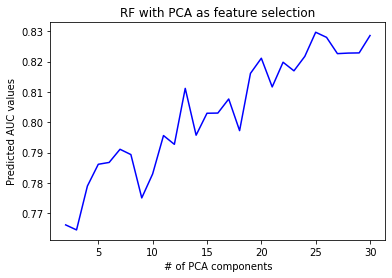

In [61]:
pca_component_x_axis = list(pca_stats.keys())
rf_score_y_axis = list(pca_stats.values())
plt.plot(pca_component_x_axis, rf_score_y_axis, color='blue')
plt.title("RF with PCA as feature selection")
plt.xlabel("# of PCA components")
plt.ylabel("Predicted AUC values");

It should be noted that filter-based feature selection methods will not necessarily lead to improving
the prediction performance. In other words the filter-based methods aims to eliminating redundant features (w.r.t to class labels). However, <b>Sequential Feature Selection (SFS)</b> is a method that
aims to select a subset of the features with the highest prediction score. <br>
Depending on the size of the feature set (number of data and number of features), length of the feature subset to be selected, and the computational power (number of parallel threads) executing the SFS method would take from <b>a couple of minutes to a few days</b>.

In [41]:
path_to_radiomics = '../features/radiomic_features_test.csv'
subject_ids ,features_names, feature_set, label_set = load_radiomic_set(path_to_radiomics)
feature_set, label_set = smote_balancing(feature_set, label_set)
seed_val = 40
feature_set, label_set = data_shuffling(feature_set, label_set, seed_val)

In [42]:
# example of using SFS integrated with RF learning algorithm
from feature_selections.feature_selectors import sequential_selection
from training.trainer import learning_with_sfs

In [43]:
# step 1: finding the most informative subset of features with SFS

n_features = 10 # define the number of features to be selected
k_fold = 5    # cross validation for feature selection

clf_model = random_forest()
sfs_model = sequential_selection(clf_model, n_features=n_features, foward_state=True, floating_state=False,
                         metric='roc_auc', k_fold=k_fold, n_jobs=-1)

feature_set_norm, _, _ = feature_normalization(feature_set, x_val = None, x_test = None)
print('Sequential feature selection is in progress ...')
sfs_summary = learning_with_sfs(sfs_model, feature_set_norm, label_set, n_features=n_features)
print('Done with sequential feature selection step!')
exp_name = str(n_features) + ' selected features_names'
selected_features = list(sfs_summary[exp_name])


Sequential feature selection is in progress ...
Done with sequential feature selection step!


In [44]:
selected_feature_name = [features_names[index] for index in selected_features]
print('The indices of selected features are {}.'.format(
    selected_features, selected_feature_name))

The indices of selected features are [313, 345, 356, 542, 575, 602, 609, 777, 789, 1053].


In [45]:
# step 2: using only selected features for cross validation
seed_val = 40
feature_set, label_set = data_shuffling(feature_set, label_set, seed_val)
feature_subset = feature_set[:, selected_features]
#feature_subset = feature_set
n_fold_split = 5
fold_num = 0
kf = KFold(n_splits = n_fold_split, shuffle = False) 
fold_stats = {}
for train_index, val_index in kf.split(label_set):
    fold_num += 1
    fold_name = 'fold_'+str(fold_num)
    print('Working on fold: {}'.format(fold_num))
    
    x_train, x_val, y_train, y_val = train_val_split(
        feature_subset, label_set, train_index, val_index)
    
    x_train, x_val, _ = feature_normalization(x_train, x_val, x_test = None)
            

    clf = random_forest(n_estimators=100, criterion='gini', max_depth=300, class_weight=None)
    clf_summary = learning(clf, x_train, y_train, x_val, y_val, x_test = None)
    fold_stats[fold_name] = clf_summary
    
mean_acc, mean_sen, mean_spc, mean_auc, _, _, _, _ = cross_val_stats(fold_stats)
print('\n'*2)
print('the average auc value of {} fold cross validation after selecting {} features with \
SFS algorithm is: {a:1.3f}'.format(n_fold_split,n_features, a=mean_auc))

Working on fold: 1
Working on fold: 2
Working on fold: 3
Working on fold: 4
Working on fold: 5



the average auc value of 5 fold cross validation after selecting 10 features with SFS algorithm is: 0.884


### <b>7. Determining robust radiomic signature <br><br>

In the previous section, we used SFS method to select a subset of features that would result in a robust prediction score. In specific, we, first, conducted the SFS method to identify the most informative feature regardless of their dependency. Then, we used only the selected features to train the same learning algorithm
by which the features were selected. These steps were executed only once. However, in real practice, it is strongly recommended to repeat the steps several times after randomly shuffle the data. In other words, after identifying the top informative features, we use the selected features to train a model several times by running the the cross validation approach with random shuffling the data. The evaluation metics, then, should be averaged
over all the experiments as the final scores. If no significant deviation of the scres observed in the repeated experiments, the selected subset of radiomic features can be considered as <b>robust radiomic signatures</b>. <br>
As an example, we provide a comprehensive instance of such approach that contains almost all the previous steps of this jupyter file:<br>

1- loading the feature set<br>
2- balancing the feature set<br>
3- feature selection with SFS<br>
4- shuffle the order of the data<br>
5- feature normalization<br>
6- cross validation with the selected features<br>
7- repeat steps 4 to 6 several times
8- averaging the evaludation score

In [46]:
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append('../../radiomics_pipeline/')

import copy
import numpy as np
from training.trainer import learning, learning_with_sfs
from learning_algorithms.models import random_forest
from feature_selections.feature_selectors import sequential_selection
from sklearn.model_selection import KFold
from data_loader.feature_loader import load_radiomic_set
from preprocessing.class_balancing import smote_balancing
from utilities.feature_tools import data_shuffling, cross_val_stats
from utilities.feature_tools import feature_normalization, train_val_split

In [47]:
path_to_radiomics = '../features/radiomic_features_test.csv'
subject_ids ,features_names, feature_set, label_set = load_radiomic_set(path_to_radiomics)
feature_set, label_set = smote_balancing(feature_set, label_set)

In [48]:
seed_val = 42
feature_set, label_set = data_shuffling(feature_set, label_set, seed_val)

In [49]:
n_features = 10
k_fold = 5 # number of folds for feature selection
n_fold_split = 5 # number of folds for cross validation after feature selection

clf_model = random_forest(n_estimators=50, criterion='gini', max_depth=10, class_weight=None)
sfs_model = sequential_selection(clf_model, n_features=n_features, foward_state=True, floating_state=False,
                         metric='roc_auc', k_fold=k_fold, n_jobs=-1)

feature_set_norm, _, _ = feature_normalization(feature_set, x_val = None, x_test = None)
print('Sequential feature selection is in progress ...')
sfs_summary = learning_with_sfs(sfs_model, feature_set_norm, label_set, n_features=n_features)
print('Done with sequential feature selection step!')
exp_name = str(n_features) + ' selected features_names'
selected_features = list(sfs_summary[exp_name])

Sequential feature selection is in progress ...
Done with sequential feature selection step!


In [50]:
rand_seeds = np.random.randint(low=0, high=2021,size=100) # generating 100 random values for initial seeds
temp_score_seeds = {}

In [51]:
counter = 0
for seed_val in rand_seeds:
    counter += 1
    print('Working on seed number:{}'.format(counter))

    feature_set_copy = copy.deepcopy(feature_set)
    subject_labels_copy = copy.deepcopy(label_set)
    top_features = selected_features
    feature_subset = feature_set_copy[:, top_features]
    length = np.arange(subject_labels_copy.shape[0])
       
    np.random.seed(seed_val)  
    np.random.shuffle(length)
    feature_subset = feature_subset[length]
    labels_subset = subject_labels_copy[length]
     
    seed_val = str(seed_val)
    kf = KFold(n_splits = n_fold_split, shuffle = False) 
    fold_stats = {}
    fold_num = 0
    for train_index, val_index in kf.split(label_set):
        fold_num += 1
        fold_name = 'fold_'+str(fold_num)
        
        x_train, x_val, y_train, y_val = train_val_split(
            feature_subset, labels_subset, train_index, val_index)
    
        x_train, x_val, _ = feature_normalization(x_train, x_val, x_test = None)

        clf = random_forest(n_estimators=100, criterion='gini', max_depth=300, class_weight=None)
        clf_summary = learning(clf, x_train, y_train, x_val, y_val, x_test = None)
        fold_stats[fold_name] = clf_summary
    
    _, _, _, mean_auc, _, _, _, _ = cross_val_stats(fold_stats)
   
    temp_score_seeds[seed_val] = mean_auc

Working on seed number:1
Working on seed number:2
Working on seed number:3
Working on seed number:4
Working on seed number:5
Working on seed number:6
Working on seed number:7
Working on seed number:8
Working on seed number:9
Working on seed number:10
Working on seed number:11
Working on seed number:12
Working on seed number:13
Working on seed number:14
Working on seed number:15
Working on seed number:16
Working on seed number:17
Working on seed number:18
Working on seed number:19
Working on seed number:20
Working on seed number:21
Working on seed number:22
Working on seed number:23
Working on seed number:24
Working on seed number:25
Working on seed number:26
Working on seed number:27
Working on seed number:28
Working on seed number:29
Working on seed number:30
Working on seed number:31
Working on seed number:32
Working on seed number:33
Working on seed number:34
Working on seed number:35
Working on seed number:36
Working on seed number:37
Working on seed number:38
Working on seed numbe

In [52]:
predicted_auc_values = list(temp_score_seeds.values())
mean_auc_scores = np.mean(np.array(predicted_auc_values))
std_auc_scores = np.std(np.array(predicted_auc_values))
print('running 5fold cv for 100 times resulted an AUC average score of {a:1.3f} with {b:1.3f} standard deviation' \
      .format(a=mean_auc_scores,b=std_auc_scores))

running 5fold cv for 100 times resulted an AUC average score of 0.893 with 0.003 standard deviation


With the observed results, now, we can consider the selected radiomic features "selected_features" as radiomic signatures for this feature set.

### <b>8. Final notes on model validation <br><br>

In some tasks such as challenges, in addition to train and validation sets, test set would be available as well.
In such cases, we often don't have the class labels(targets) of the test set and the task is to develop a predictive model by using train and validation sets and validate the developed model on the test set.<br>
In the following we simulate this practice:<br>
1- loading the feature set<br>
2- balancing the feature set<br>
3- shuffle the order of the data<br>
4- splitting the feature set into train and test sets<br>
5- building a predictive model by using train set<br>
$\;\;\;\;\;\;$the train set will be splitted into train and validation subsets <br>
6- the model with the best performance over the validation subset is selected to predict the labels of unseen (test) dataset.<br>
7- the predicted probabilities of the test set will be compared against the class labels of test data

In [53]:
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append('../../radiomics_pipeline/')

import copy
import numpy as np
from training.trainer import learning, learning_with_sfs
from learning_algorithms.models import random_forest
from feature_selections.feature_selectors import sequential_selection
from sklearn.model_selection import KFold
from data_loader.feature_loader import load_radiomic_set
from preprocessing.class_balancing import smote_balancing
from utilities.feature_tools import data_shuffling, cross_val_stats
from utilities.feature_tools import feature_normalization, train_val_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [54]:
path_to_radiomics = '../features/radiomic_features_test.csv'
subject_ids ,features_names, feature_set, label_set = load_radiomic_set(path_to_radiomics)
feature_set, label_set = smote_balancing(feature_set, label_set)

In [55]:
seed_val = 180 # set a random integer
feature_set, label_set = data_shuffling(feature_set, label_set, seed_val)

In [56]:
# assign 15% of all data to test set and use the rest as train/validation sets.
feature_subset, x_test, label_subset, y_test = train_test_split(feature_set, label_set, test_size=0.15, random_state=42)

In [57]:
# select a subset of features
n_features = 10
k_fold = 5
n_fold_split = 5

clf_model = random_forest(n_estimators=50, criterion='gini', max_depth=10, class_weight=None)
sfs_model = sequential_selection(clf_model, n_features=n_features, foward_state=True, floating_state=False,
                         metric='roc_auc', k_fold=k_fold, n_jobs=-1)

feature_set_norm, _, _ = feature_normalization(feature_subset, x_val = None, x_test = None)
print('Sequential feature selection is in progress ...')
sfs_summary = learning_with_sfs(sfs_model, feature_set_norm, label_subset, n_features=n_features)
print('Done with sequential feature selection step!')
exp_name = str(n_features) + ' selected features_names'
selected_features = list(sfs_summary[exp_name])

Sequential feature selection is in progress ...
Done with sequential feature selection step!


In [58]:
rand_seeds = np.random.randint(low=0, high=2021,size=100) # generating 100 random values for initial seeds.

In [59]:
# cross validating several times with only selected features
temp_score_seeds = {}
seed_summary = {}


counter = 0
for seed_val in rand_seeds:
    counter += 1
    print('Working on seed number:{}'.format(counter))

    feature_set_copy = copy.deepcopy(feature_subset)
    subject_labels_copy = copy.deepcopy(label_subset)
    x_test_copy = copy.deepcopy(x_test)
    
    top_features = selected_features
    train_val_set = feature_set_copy[:, top_features]
    x_test_copy = x_test_copy[:, top_features]
    length = np.arange(subject_labels_copy.shape[0])
       
    np.random.seed(seed_val)  
    np.random.shuffle(length)
    train_val_set = train_val_set[length]
    train_val_labels = subject_labels_copy[length]
     
    seed_val = str(seed_val)
    kf = KFold(n_splits = n_fold_split, shuffle = False) 
    fold_stats = {}
    fold_num = 0
    for train_index, val_index in kf.split(train_val_labels):
        fold_num += 1
        fold_name = 'fold_'+str(fold_num)
        
        x_train, x_val, y_train, y_val = train_val_split(
            train_val_set, train_val_labels, train_index, val_index)
    
        x_train, x_val, x_unseen = feature_normalization(x_train, x_val, x_test = x_test_copy)

        clf = random_forest(n_estimators=100, criterion='gini', max_depth=300, class_weight=None)
        clf_summary = learning(clf, x_train, y_train, x_val, y_val, x_test = x_unseen)
        fold_stats[fold_name] = clf_summary
    
    _, _, _, mean_auc_val, _, _, _, _ = cross_val_stats(fold_stats)
   
    temp_score_seeds[seed_val] = mean_auc_val
    seed_summary[seed_val] = fold_stats

Working on seed number:1
Working on seed number:2
Working on seed number:3
Working on seed number:4
Working on seed number:5
Working on seed number:6
Working on seed number:7
Working on seed number:8
Working on seed number:9
Working on seed number:10
Working on seed number:11
Working on seed number:12
Working on seed number:13
Working on seed number:14
Working on seed number:15
Working on seed number:16
Working on seed number:17
Working on seed number:18
Working on seed number:19
Working on seed number:20
Working on seed number:21
Working on seed number:22
Working on seed number:23
Working on seed number:24
Working on seed number:25
Working on seed number:26
Working on seed number:27
Working on seed number:28
Working on seed number:29
Working on seed number:30
Working on seed number:31
Working on seed number:32
Working on seed number:33
Working on seed number:34
Working on seed number:35
Working on seed number:36
Working on seed number:37
Working on seed number:38
Working on seed numbe

In [60]:
employed_seed_vals = list(temp_score_seeds.keys())    
predicted_auc_values = list(temp_score_seeds.values())
mean_auc_scores = np.mean(np.array(predicted_auc_values))
std_auc_scores = np.std(np.array(predicted_auc_values))
print('running 5fold cv for 100 times resulted an AUC average score of {a:1.3f} with {b:1.3f} standard deviation' \
      .format(a=mean_auc_scores,b=std_auc_scores))

running 5fold cv for 100 times resulted an AUC average score of 0.892 with 0.003 standard deviation


In [61]:
# findind the best performance among different seeds
max_auc_val = max(predicted_auc_values)
max_auc_val_index = predicted_auc_values.index(max_auc_val)
best_seed_val = employed_seed_vals[max_auc_val_index]
best_seed_experiment = seed_summary[best_seed_val]
test_set_scores = np.zeros((len(x_test), n_fold_split), dtype=float)

In [62]:
# quantifying the performance of the best model over the test set.
cnd = 0
for key, val in best_seed_experiment.items():
    
    test_set_scores[:,cnd]= val['test_pred_prob']
    cnd +=1
mean_test_scores = np.mean(test_set_scores, axis=1)


unseen_test_auc = roc_auc_score(y_test, mean_test_scores)
print('The AUC value of test set is {}'.format(unseen_test_auc))

The AUC value of test set is 0.8807541059449455


In [63]:
print('average AUC value over validation set is {a:1.3} and the predicted AUC value for test set is {b:1.3}'.format(a=mean_auc_scores,b=unseen_test_auc))

average AUC value over validation set is 0.892 and the predicted AUC value for test set is 0.881


As can be seen, the performance of the model over validation and test sets is almost similar. 